In [1]:
import torch.nn as nn
import torch.optim as op

In [2]:
import os
base_dir = r'D:\Python\Projects\face-reidentification\liveness_detect\Data600\Data'
train_dir = os.path.join(base_dir, 'train') ## Train Dataset
validation_dir = os.path.join(base_dir, 'val') ## Validation Dataset

In [3]:
train_live_dir = os.path.join(train_dir, 'Live')
train_spoof_dir = os.path.join(train_dir, 'Spoof')

validation_live_dir = os.path.join(validation_dir, 'Live')
validation_spoof_dir = os.path.join(validation_dir, 'Spoof')

In [4]:
from torchvision import transforms

train_trans = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.GaussianBlur(3, (0.1, 2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_trans = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_trans)
val_dataset = ImageFolder(validation_dir, transform=test_trans)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [6]:
class Anti_Spoofing(nn.Module):
    def __init__(self):
        super(Anti_Spoofing, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*16*16, 512)
        self.fc2 = nn.Linear(512, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.norm1(self.conv1(x))))
        x = self.pool(self.relu(self.norm2(self.conv2(x))))
        x = self.pool(self.relu(self.norm3(self.conv3(x))))
        x = x.view(-1, 64*16*16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

In [7]:
# class Focal_Loss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, reduction='mean'):
#         super(Focal_Loss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
#         # Use BCE loss without reduction to compute per-element loss
#         self.bce = nn.BCELoss(reduction='none')
#
#     def forward(self, inputs, targets):
#         bce_loss = self.bce(inputs, targets)
#         pt = torch.exp(-bce_loss)
#         '''
#         Focal loss = -α * (1 – pt)^γ * log(pt), since BCE loss itself is –log(pt)
#         => Focal loss = α * (1 – pt)^γ * BCE loss
#         '''
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
#
#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         elif self.reduction == 'sum':
#             return focal_loss.sum()
#         else:
#             return focal_loss

Epoch 1/20: Train Loss: 2.5537, Train Acc: 80.83%, Test Loss: 1.2313, Test Acc: 85.00%
Epoch 2/20: Train Loss: 2.4815, Train Acc: 85.21%, Test Loss: 1.7105, Test Acc: 89.17%
Epoch 3/20: Train Loss: 1.0224, Train Acc: 90.21%, Test Loss: 0.4797, Test Acc: 93.33%
Epoch 4/20: Train Loss: 0.4352, Train Acc: 89.79%, Test Loss: 0.3805, Test Acc: 93.33%
Epoch 5/20: Train Loss: 0.2642, Train Acc: 92.29%, Test Loss: 0.3315, Test Acc: 88.33%
Epoch 6/20: Train Loss: 0.1582, Train Acc: 93.96%, Test Loss: 0.3505, Test Acc: 89.17%
Epoch 7/20: Train Loss: 0.1168, Train Acc: 95.83%, Test Loss: 0.2690, Test Acc: 92.50%
Epoch 8/20: Train Loss: 0.1263, Train Acc: 95.00%, Test Loss: 0.4572, Test Acc: 85.83%
Epoch 9/20: Train Loss: 0.0979, Train Acc: 95.83%, Test Loss: 0.2745, Test Acc: 90.00%
Epoch 10/20: Train Loss: 0.1044, Train Acc: 94.79%, Test Loss: 0.3231, Test Acc: 90.83%
Epoch 11/20: Train Loss: 0.0725, Train Acc: 96.88%, Test Loss: 0.2357, Test Acc: 93.33%
Epoch 12/20: Train Loss: 0.0834, Train Ac

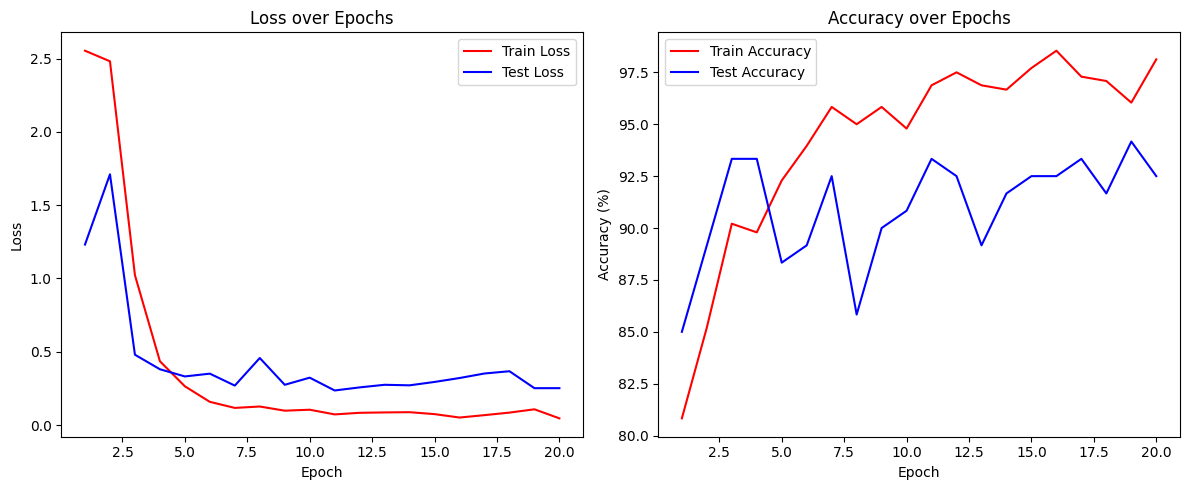

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

model = Anti_Spoofing().cuda()
criterion = nn.BCELoss()
optimizer = op.Adam(model.parameters())

# Testing function calculates loss and accuracy on the test data.
def test_model(model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    test_loss = running_loss / len(val_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

# Training and validation loop that records training and testing metrics.
def train_and_validate(model, criterion, optimizer, num_epochs=20):
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Testing phase
        test_loss, test_accuracy = test_model(model, criterion)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    print(f'Average accuracy')

    return {"train_loss": train_loss_history, "train_acc": train_acc_history,
            "test_loss": test_loss_history, "test_acc": test_acc_history}

# Run training and testing
history = train_and_validate(model, criterion, optimizer, num_epochs=20)

# Plot loss and accuracy curves for training and testing
epochs = list(range(1, len(history["train_loss"]) + 1))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], "r-", label="Train Loss")
plt.plot(epochs, history["test_loss"], "b-", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], "r-", label="Train Accuracy")
plt.plot(epochs, history["test_acc"], "b-", label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20: Train Loss: 2.8420, Train Acc: 76.67%, Test Loss: 1.0692, Test Acc: 88.33%
Epoch 2/20: Train Loss: 0.5650, Train Acc: 87.50%, Test Loss: 0.6148, Test Acc: 95.00%
Epoch 3/20: Train Loss: 0.3294, Train Acc: 88.54%, Test Loss: 0.2628, Test Acc: 95.00%
Epoch 4/20: Train Loss: 0.1909, Train Acc: 92.71%, Test Loss: 0.2083, Test Acc: 95.83%
Epoch 5/20: Train Loss: 0.1624, Train Acc: 93.75%, Test Loss: 0.2165, Test Acc: 95.00%
Epoch 6/20: Train Loss: 0.1294, Train Acc: 93.96%, Test Loss: 0.2265, Test Acc: 93.33%
Epoch 7/20: Train Loss: 0.1353, Train Acc: 95.62%, Test Loss: 0.2676, Test Acc: 90.83%
Epoch 8/20: Train Loss: 0.1425, Train Acc: 94.79%, Test Loss: 0.2567, Test Acc: 94.17%
Epoch 9/20: Train Loss: 0.0876, Train Acc: 96.25%, Test Loss: 0.3516, Test Acc: 92.50%
Epoch 10/20: Train Loss: 0.1846, Train Acc: 92.29%, Test Loss: 0.2908, Test Acc: 90.83%
Epoch 11/20: Train Loss: 0.1182, Train Acc: 95.42%, Test Loss: 0.2169, Test Acc: 90.83%
Epoch 12/20: Train Loss: 0.1701, Train Ac

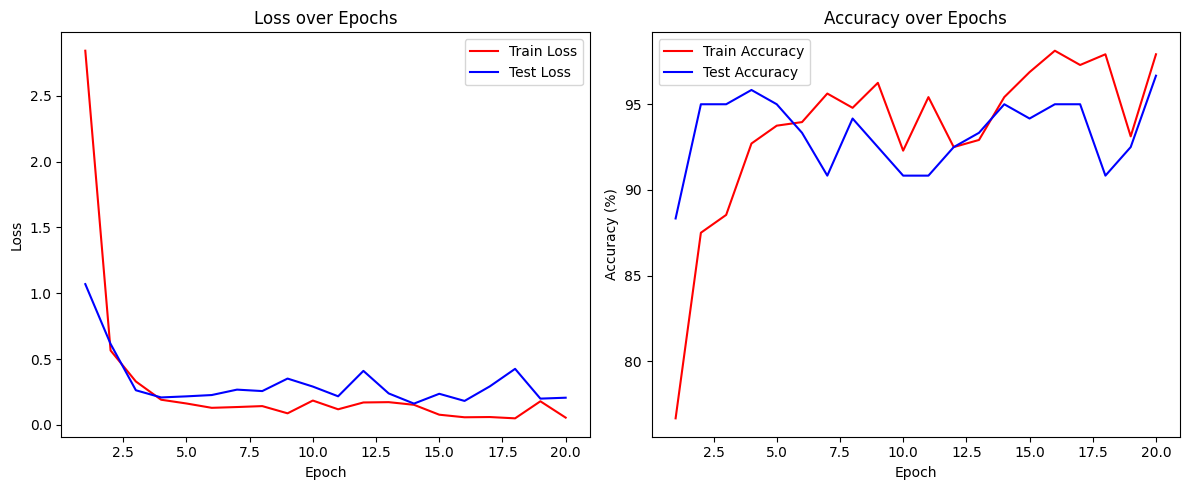

In [ ]:
# Change all the Normalization prarameter => 0.5

In [8]:
torch.save(model.state_dict(), 'model.pt')